# Predicting Activity with a Look-back 
Multilayer Perceptron

... i.e., first attempts at time dependence, with PCA and with full dataset

In [2]:
import numpy
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# fix random seed for reproducibility
seed = 66
numpy.random.seed(seed)

data = pandas.read_csv("../data/processed/train.csv")
notnull_data = data[data.notnull().all(axis=1)]
train = notnull_data.values
data2 = pandas.read_csv("../data/processed/test.csv")
notnull_data2 = data2[data2.notnull().all(axis=1)]
test = notnull_data2.values

Using Theano backend.


In [3]:
X_train = train[:,3:7558].astype(float)
#X_train = train[:,3:13].astype(float)
Y_train = train[:,7558]
X_test = test[:,3:7558].astype(float)
#X_test = test[:,3:13].astype(float)
Y_test = test[:,7558]

# One hot encoding of the response variable (using dummy variables)
from keras.utils.np_utils import to_categorical

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y_train)
encoded_Y_train = encoder.transform(Y_train)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_train = to_categorical(encoded_Y_train)
encoder.fit(Y_test)
encoded_Y_test = encoder.transform(Y_test)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_test = to_categorical(encoded_Y_test)

# Sanity check on matrix dimensions, after droppinig null/nans
#print X_train.shape #(4472, 7555)
#print Y_test.shape #(1044, )
#print dummy_y_test.shape # (1044, 5)


In [4]:
# We standardize on the basis of the training data
scaler = StandardScaler().fit(X_train)
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

# We do PCA, too
from sklearn import decomposition
n_comp = 100
pca = decomposition.PCA(n_components=n_comp)
X_train_pca = pca.fit_transform(X_train_st)
X_test_pca = pca.transform(X_test_st)

print 'Variance explained:'
print pca.explained_variance_ratio_
print 'Total variance explained by '+str(n_comp)+' components:'
print sum(pca.explained_variance_ratio_)

Variance explained:
[ 0.19505564  0.08295663  0.04067402  0.02174272  0.01775119  0.01686748
  0.01440615  0.01150575  0.01055     0.00958828  0.00877439  0.00790115
  0.007298    0.00704889  0.0066142   0.00595329  0.00538577  0.00530285
  0.00491633  0.0045751   0.00440203  0.00436509  0.00395662  0.00343414
  0.00340722  0.00328142  0.00325585  0.00305899  0.00297009  0.00289683
  0.00281987  0.00273652  0.00266189  0.00265268  0.00260069  0.0024912
  0.00238337  0.00232648  0.00226495  0.00224082  0.00221907  0.00217391
  0.00215321  0.00208428  0.00204535  0.00198475  0.00192726  0.00190714
  0.00187787  0.00183914  0.00176811  0.00173735  0.00169542  0.00166308
  0.00165403  0.00162881  0.00161277  0.0015787   0.00157364  0.00155227
  0.0015123   0.00149719  0.00148685  0.00147954  0.00145035  0.00142099
  0.00141436  0.00141164  0.00138952  0.00136064  0.00134219  0.0013185
  0.00130973  0.00129871  0.00129763  0.0012655   0.00125215  0.00124378
  0.00122832  0.0012048   0.00119

In [39]:
# We create the look-back dataset
#print train[:,1:3] # session is [1], timestamp is [2]

# convert an array of values into a dataset matrix, depending on the nr. of steps to look back
def create_dataset(sessiontimes, X, Y, look_back=1):
    dataX, dataY = [], []
    if((sessiontimes.shape[0] != X.shape[0]) or 
       (sessiontimes.shape[0] != Y.shape[0])):
        # Different number of rows, something's wrong!
        print 'Dimensions of the X, Y and timestamps do not match!!'
        return None
    sessions = numpy.unique(sessiontimes[:,0])
    for session in sessions:
        print session
        stimes = sessiontimes[numpy.where(sessiontimes[:,0] == session)]
        sessionX = X[numpy.where(sessiontimes[:,0] == session)]
        sessionY = Y[numpy.where(sessiontimes[:,0] == session)]
        sessiondataX, sessiondataY = [], []
        # For Y, we just eliminate the first look_back rows
        sessiondataY = sessionY[look_back:sessionY.shape[0],:]
        # For X, se successively roll and append the data, then eliminate the first look_back rows
        for i in range(look_back+1):
            rolled = numpy.roll(sessionX,i,axis=0)
            if(i == 0):
                sessiondataX = numpy.array(rolled)
            else:
                sessiondataX = numpy.hstack((sessiondataX, numpy.array(rolled)))
        sessiondataX = sessiondataX[look_back:(sessiondataX.shape[0]),:]
        # We join all the sessions data
        if len(dataX)==0:
            dataX = sessiondataX
            dataY = sessiondataY
        else:
            dataX = numpy.vstack((dataX, sessiondataX))
            dataY = numpy.vstack((dataY, sessiondataY))
    return dataX, dataY

# reshape into X=t and Y=t+1
lookbk = 9
X_train_lb, Y_train_lb = create_dataset(train[:,1:3], X_train_pca, dummy_y_train, lookbk)
X_test_lb, Y_test_lb = create_dataset(test[:,1:3], X_test_pca, dummy_y_test, lookbk)
print X_train_lb.shape, Y_test_lb.shape


case1-day1-session2-teacher1
case1-day1-session3-teacher1
case1-day1-session4-teacher1
case2-day1-session1-teacher2
case2-day1-session2-teacher2
case2-day2-session1-teacher2
case2-day2-session2-teacher2
case2-day3-session2-teacher2
case2-day4-session1-teacher2
case2-day4-session2-teacher2
case1-day1-session1-teacher1
case2-day3-session1-teacher2
(4382, 1000) (1026, 5)


In [40]:
from keras.layers import Dropout
from keras.constraints import maxnorm
from keras.optimizers import SGD

# baseline model
def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(200, input_dim=7555, init='uniform', activation='tanh', W_constraint=maxnorm(4)))
    model.add(Dense(20, init='uniform', activation='tanh', W_constraint=maxnorm(4)))
    model.add(Dense(5, init='uniform', activation='sigmoid'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Apply dropout regularization, it is overfitting!
def create_dropout():
    # create model
    model = Sequential()
    model.add(Dropout(0.2, input_shape=(7555,)))
    model.add(Dense(200, init='uniform', activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(20, init='uniform', activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(5, init='uniform', activation='sigmoid'))
    # Compile model, with larger learning rate and momentum, as recommended by the original paper
    sgd = SGD(lr=0.01, momentum=0.9, decay=0.0, nesterov=False)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

# Apply dropout regularization, it is overfitting!
def create_dropout_decay():
    # create model
    model = Sequential()
    model.add(Dropout(0.2, input_shape=(7555,)))
    model.add(Dense(200, init='uniform', activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(20, init='uniform', activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(5, init='uniform', activation='sigmoid'))
    # Compile model, with larger learning rate and momentum, as recommended by the original paper
    sgd = SGD(lr=0.1, momentum=0.9, decay=0.005, nesterov=False)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

# Apply dropout regularization, it is overfitting!
def create_deeper_dropout_decay_PCA(n_components, lookback, learningrate, n_epochs):
    # create model
    model = Sequential()
    model.add(Dropout(0.2, input_shape=(n_components*(lookback+1),)))
    model.add(Dense(300, init='uniform', activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(300, init='uniform', activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(80, init='uniform', activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(80, init='uniform', activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(20, init='uniform', activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(20, init='uniform', activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(5, init='uniform', activation='sigmoid'))
    # Compile model, with larger learning rate and momentum, as recommended by the original paper
    sgd = SGD(lr=learningrate, momentum=0.8, decay=learningrate/n_epochs, nesterov=False)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

# evaluate baseline model with standardized dataset
numpy.random.seed(seed)
#estimators = []
#estimators.append(('standardize', StandardScaler()))
#estimators.append(('mlp', KerasClassifier(build_fn=create_baseline, nb_epoch=10, batch_size=10, verbose=1)))
# We define a pipeline of estimators, in which first the scaler is fitted to the data, then the MLP is applied
#pipeline = Pipeline(estimators)
#kfold = StratifiedKFold(y=Y_train, n_folds=3, shuffle=True, random_state=seed)
#model = create_baseline()
learningrate = 0.1
n_epochs = 1000
model = create_deeper_dropout_decay_PCA(n_components=n_comp, lookback=lookbk, learningrate=learningrate, n_epochs=n_epochs)
print model.summary()



____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dropout_22 (Dropout)             (None, 1000)          0           dropout_input_4[0][0]            
____________________________________________________________________________________________________
dense_22 (Dense)                 (None, 300)           300300      dropout_22[0][0]                 
____________________________________________________________________________________________________
dropout_23 (Dropout)             (None, 300)           0           dense_22[0][0]                   
____________________________________________________________________________________________________
dense_23 (Dense)                 (None, 300)           90300       dropout_23[0][0]                 
___________________________________________________________________________________________

In [41]:
from keras.callbacks import ModelCheckpoint

# To save the best model
# serialize model to JSON
model_json = model.to_json()
with open("model--7mlp--lb.json", "w") as json_file:
    json_file.write(model_json)
filepath="weights--7mlp--lb.best.hdf5"
# Define that the accuracy in cv is monitored, and that weights are stored in a file when max accuracy is achieved
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# Fit the model
history = model.fit(X_train_lb, Y_train_lb, validation_data=(X_test_lb,Y_test_lb), 
                    nb_epoch=n_epochs, batch_size=10, verbose=0, callbacks=callbacks_list)
#results = cross_val_score(pipeline, X_train, dummy_y_train, cv=kfold)
#print("Standardized data Acc (in CV training data): %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
# evaluate the model
#scores = pipeline.evaluate(X_test, dummy_y_test)
#print pipeline.metrics_names[1]
#print scores[1]*100
# For other metrics, see http://machinelearningmastery.com/metrics-evaluate-machine-learning-algorithms-python/



Epoch 00000: val_acc improved from -inf to 0.47661, saving model to weights--7mlp--lb.best.hdf5
Epoch 00001: val_acc improved from 0.47661 to 0.50487, saving model to weights--7mlp--lb.best.hdf5
Epoch 00002: val_acc improved from 0.50487 to 0.50877, saving model to weights--7mlp--lb.best.hdf5
Epoch 00003: val_acc did not improve
Epoch 00004: val_acc did not improve
Epoch 00005: val_acc did not improve
Epoch 00006: val_acc did not improve
Epoch 00007: val_acc improved from 0.50877 to 0.51072, saving model to weights--7mlp--lb.best.hdf5
Epoch 00008: val_acc did not improve
Epoch 00009: val_acc did not improve
Epoch 00010: val_acc did not improve
Epoch 00011: val_acc did not improve
Epoch 00012: val_acc improved from 0.51072 to 0.54191, saving model to weights--7mlp--lb.best.hdf5
Epoch 00013: val_acc did not improve
Epoch 00014: val_acc did not improve
Epoch 00015: val_acc did not improve
Epoch 00016: val_acc did not improve
Epoch 00017: val_acc did not improve
Epoch 00018: val_acc did no

(1026, 5)
Accuracy:
0.598440545809
Confusion matrix:
[[161   3  19  11   0]
 [  6 234  38  15  32]
 [ 57  80 136  25  27]
 [ 25   6  25  34   5]
 [  5  24   5   4  49]]
AUC score:
0.816970897963


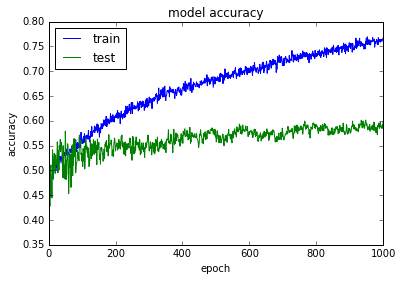

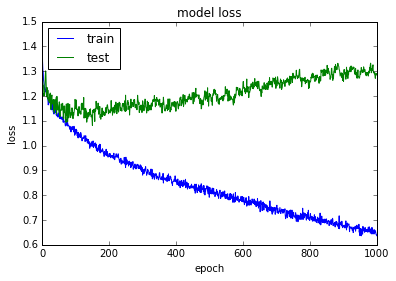

In [42]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score

# TODO: Reload the best model and weights from the previous step, before showing the evaluation


# Other performance/accuracy metrics
Y_pred = model.predict(X_test_lb)
print Y_pred.shape

# Accuracy
print('Accuracy:')
print(accuracy_score(numpy.argmax(Y_test_lb, axis=1), numpy.argmax(Y_pred, axis=1)))


# Confusion matrix
cm = confusion_matrix(numpy.argmax(Y_test_lb, axis=1), numpy.argmax(Y_pred, axis=1))
numpy.set_printoptions(precision=2)
print('Confusion matrix:')
print(cm)

# AUC
roc = roc_auc_score(Y_test_lb, Y_pred, average='macro')
print('AUC score:')
print(roc)
    

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()



So, the lookback MLP approach (from 100-component PCA) seems to work a bit better (and beat the raw random forest), but not by much.

# Predicting social plane, using PCA-MLP and lookback

... similar to the previous one.

In [45]:
X_train = train[:,3:7558].astype(float)
#X_train = train[:,3:13].astype(float)
Y_train = train[:,7559]
X_test = test[:,3:7558].astype(float)
#X_test = test[:,3:13].astype(float)
Y_test = test[:,7559]

# One hot encoding of the response variable (using dummy variables)
from keras.utils.np_utils import to_categorical

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y_train)
encoded_Y_train = encoder.transform(Y_train)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_train = to_categorical(encoded_Y_train)
encoder.fit(Y_test)
encoded_Y_test = encoder.transform(Y_test)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_test = to_categorical(encoded_Y_test)

# Sanity check on matrix dimensions, after droppinig null/nans
#print X_train.shape #(4472, 7555)
#print Y_test.shape #(1044, )
#print dummy_y_test.shape # (1044, 5)


In [46]:
# We standardize on the basis of the training data
scaler = StandardScaler().fit(X_train)
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

# We do PCA, too
from sklearn import decomposition
n_comp = 100
pca = decomposition.PCA(n_components=n_comp)
X_train_pca = pca.fit_transform(X_train_st)
X_test_pca = pca.transform(X_test_st)

print 'Variance explained:'
print pca.explained_variance_ratio_
print 'Total variance explained by '+str(n_comp)+' components:'
print sum(pca.explained_variance_ratio_)

Variance explained:
[ 0.2   0.08  0.04  0.02  0.02  0.02  0.01  0.01  0.01  0.01  0.01  0.01
  0.01  0.01  0.01  0.01  0.01  0.01  0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
Total variance explained by 100 components:
0.630815671837


In [47]:
# We create the look-back dataset
#print train[:,1:3] # session is [1], timestamp is [2]

# convert an array of values into a dataset matrix, depending on the nr. of steps to look back
def create_dataset(sessiontimes, X, Y, look_back=1):
    dataX, dataY = [], []
    if((sessiontimes.shape[0] != X.shape[0]) or 
       (sessiontimes.shape[0] != Y.shape[0])):
        # Different number of rows, something's wrong!
        print 'Dimensions of the X, Y and timestamps do not match!!'
        return None
    sessions = numpy.unique(sessiontimes[:,0])
    for session in sessions:
        print session
        stimes = sessiontimes[numpy.where(sessiontimes[:,0] == session)]
        sessionX = X[numpy.where(sessiontimes[:,0] == session)]
        sessionY = Y[numpy.where(sessiontimes[:,0] == session)]
        sessiondataX, sessiondataY = [], []
        # For Y, we just eliminate the first look_back rows
        sessiondataY = sessionY[look_back:sessionY.shape[0],:]
        # For X, se successively roll and append the data, then eliminate the first look_back rows
        for i in range(look_back+1):
            rolled = numpy.roll(sessionX,i,axis=0)
            if(i == 0):
                sessiondataX = numpy.array(rolled)
            else:
                sessiondataX = numpy.hstack((sessiondataX, numpy.array(rolled)))
        sessiondataX = sessiondataX[look_back:(sessiondataX.shape[0]),:]
        # We join all the sessions data
        if len(dataX)==0:
            dataX = sessiondataX
            dataY = sessiondataY
        else:
            dataX = numpy.vstack((dataX, sessiondataX))
            dataY = numpy.vstack((dataY, sessiondataY))
    return dataX, dataY

# reshape into X=t and Y=t+1
lookbk = 9
X_train_lb, Y_train_lb = create_dataset(train[:,1:3], X_train_pca, dummy_y_train, lookbk)
X_test_lb, Y_test_lb = create_dataset(test[:,1:3], X_test_pca, dummy_y_test, lookbk)
print X_train_lb.shape, Y_test_lb.shape


case1-day1-session2-teacher1
case1-day1-session3-teacher1
case1-day1-session4-teacher1
case2-day1-session1-teacher2
case2-day1-session2-teacher2
case2-day2-session1-teacher2
case2-day2-session2-teacher2
case2-day3-session2-teacher2
case2-day4-session1-teacher2
case2-day4-session2-teacher2
case1-day1-session1-teacher1
case2-day3-session1-teacher2
(4382, 1000) (1026, 4)


In [50]:
from keras.layers import Dropout
from keras.constraints import maxnorm
from keras.optimizers import SGD

# Apply dropout regularization, it is overfitting!
def create_deeper_dropout_decay_PCA(n_components, lookback, learningrate, n_epochs):
    # create model
    model = Sequential()
    model.add(Dropout(0.2, input_shape=(n_components*(lookback+1),)))
    model.add(Dense(300, init='uniform', activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(300, init='uniform', activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(80, init='uniform', activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(80, init='uniform', activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(20, init='uniform', activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(20, init='uniform', activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(4, init='uniform', activation='sigmoid'))
    # Compile model, with larger learning rate and momentum, as recommended by the original paper
    sgd = SGD(lr=learningrate, momentum=0.8, decay=learningrate/n_epochs, nesterov=False)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

# evaluate baseline model with standardized dataset
numpy.random.seed(seed)
#estimators = []
#estimators.append(('standardize', StandardScaler()))
#estimators.append(('mlp', KerasClassifier(build_fn=create_baseline, nb_epoch=10, batch_size=10, verbose=1)))
# We define a pipeline of estimators, in which first the scaler is fitted to the data, then the MLP is applied
#pipeline = Pipeline(estimators)
#kfold = StratifiedKFold(y=Y_train, n_folds=3, shuffle=True, random_state=seed)
#model = create_baseline()
learningrate = 0.1
n_epochs = 20
model = create_deeper_dropout_decay_PCA(n_components=n_comp, lookback=lookbk, learningrate=learningrate, n_epochs=n_epochs)
print model.summary()



____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dropout_36 (Dropout)             (None, 1000)          0           dropout_input_6[0][0]            
____________________________________________________________________________________________________
dense_36 (Dense)                 (None, 300)           300300      dropout_36[0][0]                 
____________________________________________________________________________________________________
dropout_37 (Dropout)             (None, 300)           0           dense_36[0][0]                   
____________________________________________________________________________________________________
dense_37 (Dense)                 (None, 300)           90300       dropout_37[0][0]                 
___________________________________________________________________________________________

In [51]:
from keras.callbacks import ModelCheckpoint

# To save the best model
# serialize model to JSON
model_json = model.to_json()
with open("social.model--7mlp--lb.json", "w") as json_file:
    json_file.write(model_json)
filepath="social.weights--7mlp--lb.best.hdf5"
# Define that the accuracy in cv is monitored, and that weights are stored in a file when max accuracy is achieved
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# Fit the model
history = model.fit(X_train_lb, Y_train_lb, validation_data=(X_test_lb,Y_test_lb), 
                    nb_epoch=n_epochs, batch_size=10, verbose=0, callbacks=callbacks_list)
#results = cross_val_score(pipeline, X_train, dummy_y_train, cv=kfold)
#print("Standardized data Acc (in CV training data): %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
# evaluate the model
#scores = pipeline.evaluate(X_test, dummy_y_test)
#print pipeline.metrics_names[1]
#print scores[1]*100
# For other metrics, see http://machinelearningmastery.com/metrics-evaluate-machine-learning-algorithms-python/



Epoch 00000: val_acc improved from -inf to 0.62183, saving model to social.weights--7mlp--lb.best.hdf5
Epoch 00001: val_acc did not improve
Epoch 00002: val_acc did not improve
Epoch 00003: val_acc did not improve
Epoch 00004: val_acc did not improve
Epoch 00005: val_acc did not improve
Epoch 00006: val_acc improved from 0.62183 to 0.62378, saving model to social.weights--7mlp--lb.best.hdf5
Epoch 00007: val_acc improved from 0.62378 to 0.62768, saving model to social.weights--7mlp--lb.best.hdf5
Epoch 00008: val_acc improved from 0.62768 to 0.63743, saving model to social.weights--7mlp--lb.best.hdf5
Epoch 00009: val_acc improved from 0.63743 to 0.63840, saving model to social.weights--7mlp--lb.best.hdf5
Epoch 00010: val_acc improved from 0.63840 to 0.65497, saving model to social.weights--7mlp--lb.best.hdf5
Epoch 00011: val_acc did not improve
Epoch 00012: val_acc did not improve
Epoch 00013: val_acc did not improve
Epoch 00014: val_acc improved from 0.65497 to 0.67544, saving model to 

(1026, 4)
Accuracy:
0.671539961014
Confusion matrix:
[[631   0   0   7]
 [217   0   0   2]
 [ 23   0   1   0]
 [ 70   0  18  57]]
AUC score:
0.643159327864


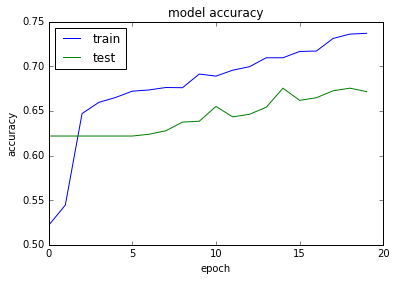

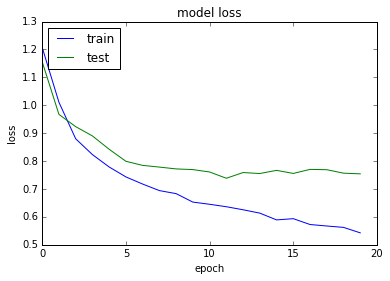

In [52]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score

# TODO: Reload the best model and weights from the previous step, before showing the evaluation


# Other performance/accuracy metrics
Y_pred = model.predict(X_test_lb)
print Y_pred.shape

# Accuracy
print('Accuracy:')
print(accuracy_score(numpy.argmax(Y_test_lb, axis=1), numpy.argmax(Y_pred, axis=1)))


# Confusion matrix
cm = confusion_matrix(numpy.argmax(Y_test_lb, axis=1), numpy.argmax(Y_pred, axis=1))
numpy.set_printoptions(precision=2)
print('Confusion matrix:')
print(cm)

# AUC
roc = roc_auc_score(Y_test_lb, Y_pred, average='macro')
print('AUC score:')
print(roc)
    

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

